## Initial imports and basic visualizations

In [2]:
import numpy as np
import pandas as pdcoding
import gzip
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from scipy.spatial.distance import cdist

In [3]:
import math
import matplotlib.lines

#HitHistogram
def HitHist(_m, _n, _weights, _idata):
    hist = np.zeros(_m * _n)
    for vector in _idata: 
        position =np.argmin(np.sqrt(np.sum(np.power(_weights - vector, 2), axis=1)))
        hist[position] += 1

    return hist.reshape(_m, _n)

#U-Matrix - implementation
def UMatrix(_m, _n, _weights, _dim):
    print("m: ", _m, " n: ", _n, " dim: ", _dim)
    U = _weights.reshape(_m, _n, _dim)
    U = np.insert(U, np.arange(1, _n), values=0, axis=1)
    U = np.insert(U, np.arange(1, _m), values=0, axis=0)
    #calculate interpolation
    for i in range(U.shape[0]): 
        if i%2==0:
            for j in range(1,U.shape[1],2):
                U[i,j][0] = np.linalg.norm(U[i,j-1] - U[i,j+1], axis=-1)
        else:
            for j in range(U.shape[1]):
                if j%2==0: 
                    U[i,j][0] = np.linalg.norm(U[i-1,j] - U[i+1,j], axis=-1)
                else:      
                    U[i,j][0] = (np.linalg.norm(U[i-1,j-1] - U[i+1,j+1], axis=-1) + np.linalg.norm(U[i+1,j-1] - U[i-1,j+1], axis=-1))/(2*np.sqrt(2))

    U = np.sum(U, axis=2) #move from Vector to Scalar

    for i in range(0, U.shape[0], 2): #count new values
        for j in range(0, U.shape[1], 2):
            region = []
            if j>0: region.append(U[i][j-1]) #check left border
            if i>0: region.append(U[i-1][j]) #check bottom
            if j<U.shape[1]-1: region.append(U[i][j+1]) #check right border
            if i<U.shape[0]-1: region.append(U[i+1][j]) #check upper border

            U[i,j] = np.median(region)

    return U

#SDH - implementation
def SDH(_m, _n, _weights, _idata, factor, approach):
    import heapq

    sdh_m = np.zeros( _m * _n)

    cs=0
    for i in range(factor): cs += factor-i

    for vector in _idata:
        dist = np.sqrt(np.sum(np.power(_weights - vector, 2), axis=1))
        c = heapq.nsmallest(factor, range(len(dist)), key=dist.__getitem__)
        if (approach==0): # normalized
            for j in range(factor):  sdh_m[c[j]] += (factor-j)/cs 
        if (approach==1):# based on distance
            for j in range(factor): sdh_m[c[j]] += 1.0/dist[c[j]] 
        if (approach==2): 
            dmin, dmax = min(dist[c]), max(dist[c])
            for j in range(factor): sdh_m[c[j]] += 1.0 - (dist[c[j]]-dmin)/(dmax-dmin)

    return sdh_m.reshape(_m, _n)




## Vectorfield visualization function

In [7]:
from collections import namedtuple
Config = namedtuple('Config', 'groups sigma enable_flow enable_borderline scaling_arrow_length')

def visualize_vector_field(_m, _n, _weights, _dim, configs):
    
	fig, axs = plt.subplots(nrows=1, ncols=len(configs))

	for a, conf in enumerate(configs):
		dimensionIndices = np.indices([_dim])[0] 

		arrowColors = ['#0000FF','#00FFFF','#FF00FF']
		borderColors = ['#FF0000','#FFC800','#808080']


		# in order to handle edges, we should to pad the array

		Ustart = _weights.reshape(_m, _n, _dim)
		# mode can be changed

		ax = axs[a]
		
		#U = np.insert(U, np.arange(1, _n), values=0, axis=1)
		#U = np.insert(U, np.arange(1, _m), values=0, axis=0)
		#display(U)

		# groups are 1, 2 or 3
		kernelCounter = -1
		for g in conf.groups:
			kernelCounter += 1        
			
			if len(g) == 0:
				print('nothing in group! ')
				continue
			
			active = np.isin(dimensionIndices,g)
			#display(active)

			if not np.any(active):
				print('group with no valid members!')
				continue   

			# a range just to add some data to the outside     
			kernelRange = 5
		
			
			kernelDiv = 1 / (2 * math.pi * (conf.sigma ** 2))
			kernelExpDiv = 2 * (conf.sigma ** 2)
			

			U = np.pad(Ustart, pad_width=((kernelRange,kernelRange),(kernelRange,kernelRange),(0,0)),mode="reflect")
			
		
			for i in range(_m):
				for j in range(_n):
					#vector = U[i, j, :2]  # Extract 2D vector component

					indices = np.indices([_m + kernelRange * 2,_n + kernelRange * 2])
					distX = indices[0,:,:] - (i + kernelRange)
					distY = indices[1,:,:] - (j + kernelRange)
					distXAbs = np.abs(distX)
					distYAbs = np.abs(distY)
					distBlock = np.maximum(distXAbs, distYAbs)
					
					distSqS = np.power(distXAbs, 2) + np.power(distYAbs, 2)

					distManhat = distXAbs + distYAbs
					blockOk = distBlock <= kernelRange

					# linear dropoff with manhattan distance
					# prevent divide by zero

					kernelFactor = kernelDiv * np.power(np.e,-distSqS/kernelExpDiv)


					xImpact = np.multiply(np.sign(distX), kernelFactor)
					yImpact = np.multiply(np.sign(distY), kernelFactor)
					#display(U[:,:,active])
					#display(np.shape(U[:,:,:]))

					# actual distances
					actualDist = np.sqrt(np.power(U[:,:,active] - U[(i + kernelRange),(j + kernelRange),active],2).sum(axis=2))
					xComponents = np.multiply(actualDist, xImpact)
					yComponents = np.multiply(actualDist, yImpact)
					xPositive = np.sum(np.clip(xComponents,a_min=0,a_max=None))
					xNegative = np.sum(np.clip(xComponents,a_max=0,a_min=None))
					yPositive = np.sum(np.clip(yComponents,a_min=0,a_max=None))
					yNegative = np.sum(np.clip(yComponents,a_max=0,a_min=None))


					xDirection = np.sum(xComponents) * conf.scaling_arrow_length
					yDirection = np.sum(yComponents) * conf.scaling_arrow_length


					angle = math.atan2(xDirection, yDirection)
					length = math.sqrt(xDirection**2 + yDirection**2)/2



					line = matplotlib.lines.Line2D(
						[j + math.sin(angle) * length, j +  math.sin(angle + math.pi) * length],
						[_m-i-1 + math.cos(angle) * length, _m-i-1 + math.cos(angle + math.pi) * length],
						linewidth= 4 * length,
						color=borderColors[kernelCounter % len(borderColors)]
						)
					arrow = FancyArrowPatch((j, _m-i-1), (j-yDirection, _m-i+xDirection-1), 
											arrowstyle='->', mutation_scale=30 * length, 
											color=arrowColors[kernelCounter % len(arrowColors)])
					if conf.enable_borderline:
						ax.add_patch(arrow)
					if conf.enable_flow:
						ax.add_line(line)
		
		ax.set_xticks(np.arange(_n + 1) - 0.5)
		ax.set_yticks(np.arange(_m + 1) - 0.5)

		ax.grid()
		ax.set_xlim(-1, _n )
		ax.set_ylim(-1, _m )
		ax.tick_params(labelbottom=False,labelleft=False)
		fig.set_figwidth(5*len(configs))
		fig.set_figheight(6)
		ax.set_aspect('equal')

		ax.grid(True)
		ax.set_title('Vector Field Visualization with Flows\nsigma=' + str(conf.sigma))

	#plt.grid(True)
	#plt.title("")
	plt.show()

## Training SOM


### Required imports

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
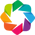

In [9]:
import panel as pn
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
import somoclu

#SOMToolbox Parser
from SOMToolBox_Parse import SOMToolBox_Parse

idataChainlink = SOMToolBox_Parse("datasets/chainlink/chainlink.vec").read_weight_file()
idataClusters = SOMToolBox_Parse("datasets/10clusters/10clusters.vec").read_weight_file()

### Training for Chainlink

#### with 10x10

In [10]:
n_rows10 = 10
n_columns10 = 10

som = somoclu.Somoclu(n_columns10, n_rows10, compactsupport= False)
som.train(idataChainlink['arr'], epochs=1000)
res_weights_chainlink10 = som.codebook

#### with 100x60

In [11]:
n_rows100 = 100
n_columns100 = 60

som = somoclu.Somoclu(n_columns100, n_rows100, compactsupport= False)
som.train(idataChainlink['arr'], epochs=1000)
res_weights_chainlink100 = som.codebook

### Training for 10-Clusters

#### with 10x10

In [16]:
n_rows10 = 10
n_columns10 = 10

som = somoclu.Somoclu(n_columns10, n_rows10, compactsupport= False)
som.train(idataClusters['arr'], epochs=1000)
res_weights_clusters10 = som.codebook

#### with 100x60

In [19]:
n_rows100 = 100
n_columns100 = 60

som = somoclu.Somoclu(n_columns100, n_rows100, compactsupport= False)
som.train(idataClusters['arr'], epochs=1000)
res_weights_clusters100 = som.codebook

## Visualization of trained SOMs


### Visualization of Chainlink

#### with 10x10

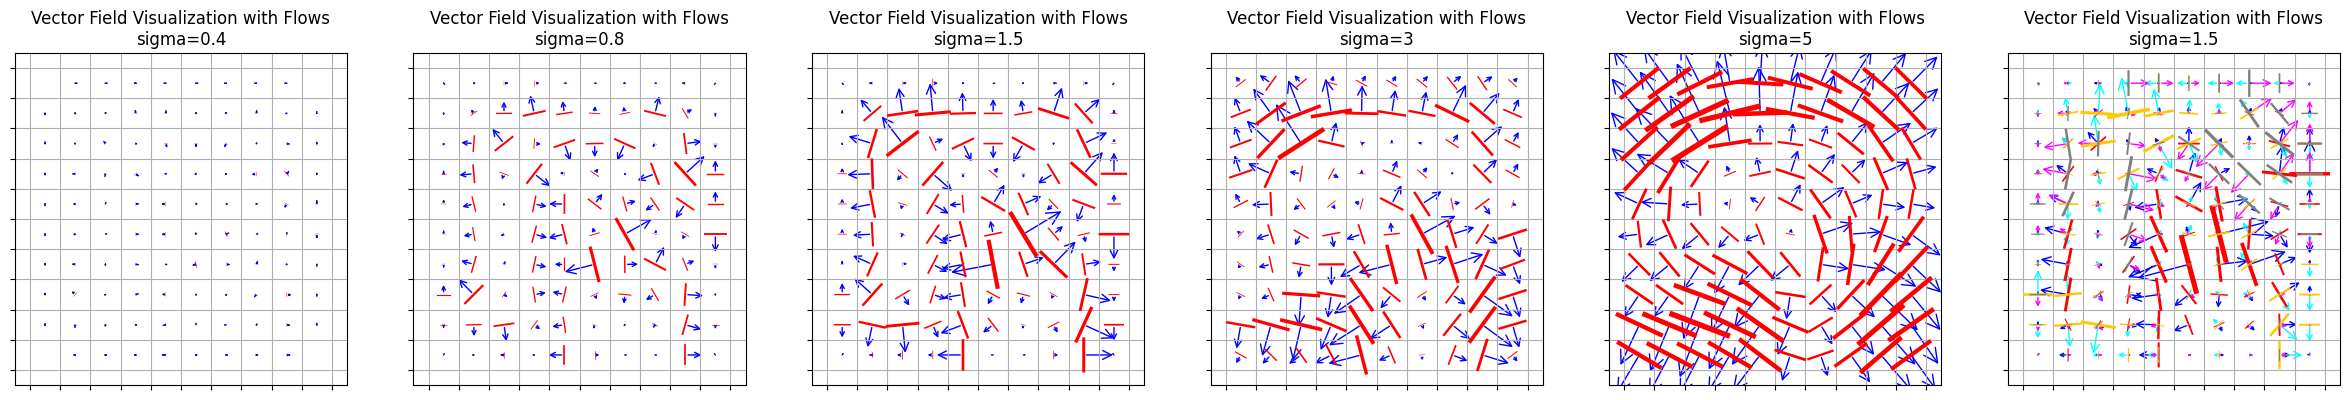

In [13]:
visualize_vector_field(n_rows10, n_columns10, res_weights_chainlink10, idataChainlink['vec_dim'], [
	Config([[0,1,2]], 0.4, True, True, 5), 
	Config([[0,1,2]], 0.8, True, True, 5), 
	Config([[0,1,2]], 1.5, True, True, 5), 
	Config([[0,1,2]], 3, True, True, 5), 
	Config([[0,1,2]], 5, True, True, 5), 
	Config([[0],[1],[2]], 1.5, True, True, 5)])

#### with 100x60

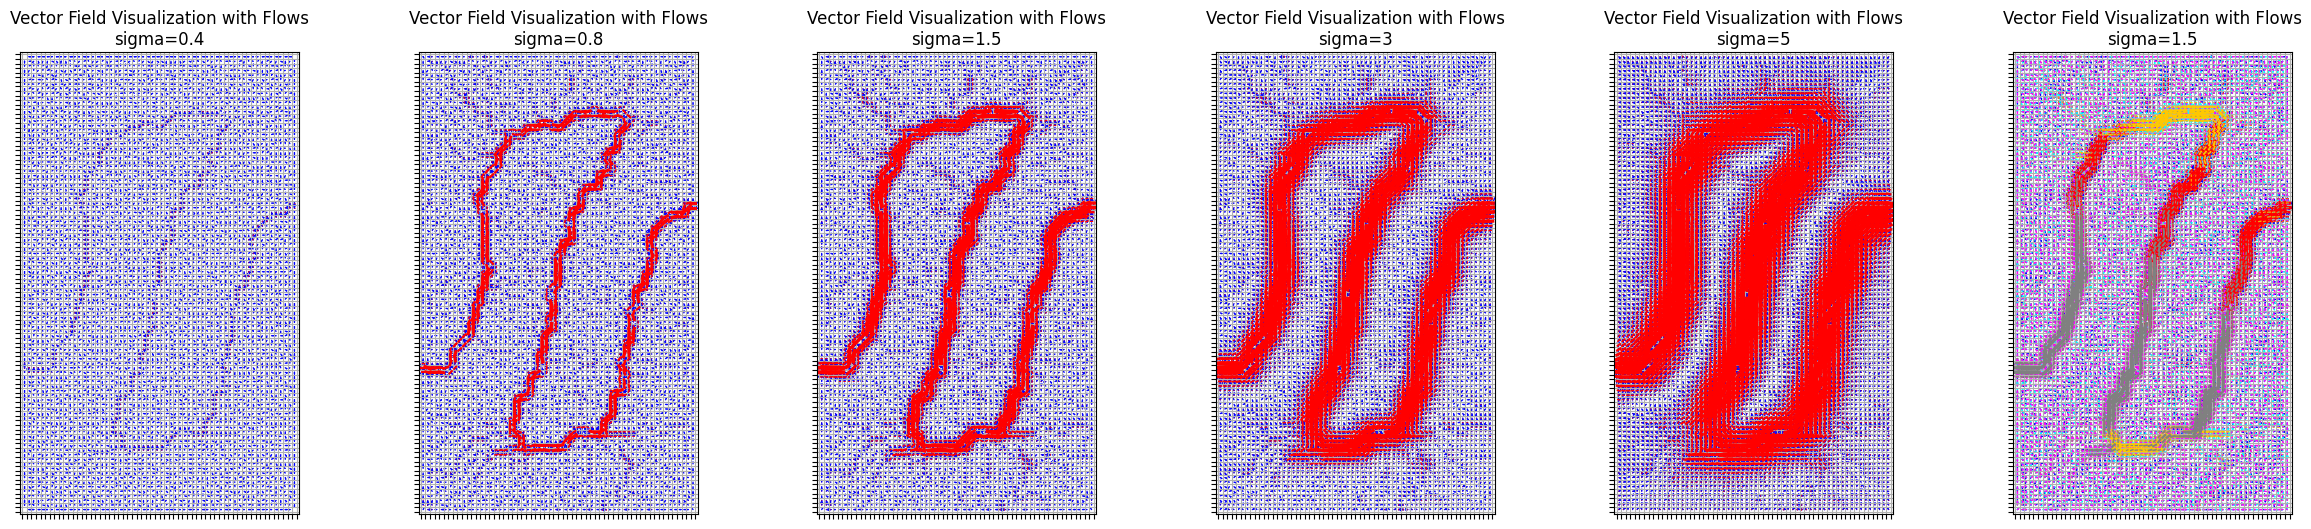

In [14]:
visualize_vector_field(n_rows100, n_columns100, res_weights_chainlink100, idataChainlink['vec_dim'], [
	Config([[0,1,2]], 0.4, True, True, 5), 
	Config([[0,1,2]], 0.8, True, True, 5), 
	Config([[0,1,2]], 1.5, True, True, 5), 
	Config([[0,1,2]], 3, True, True, 5), 
	Config([[0,1,2]], 5, True, True, 5), 
	Config([[0],[1],[2]], 1.5, True, True, 5)])


### Visualization of 10-Clusters

#### with 10x10

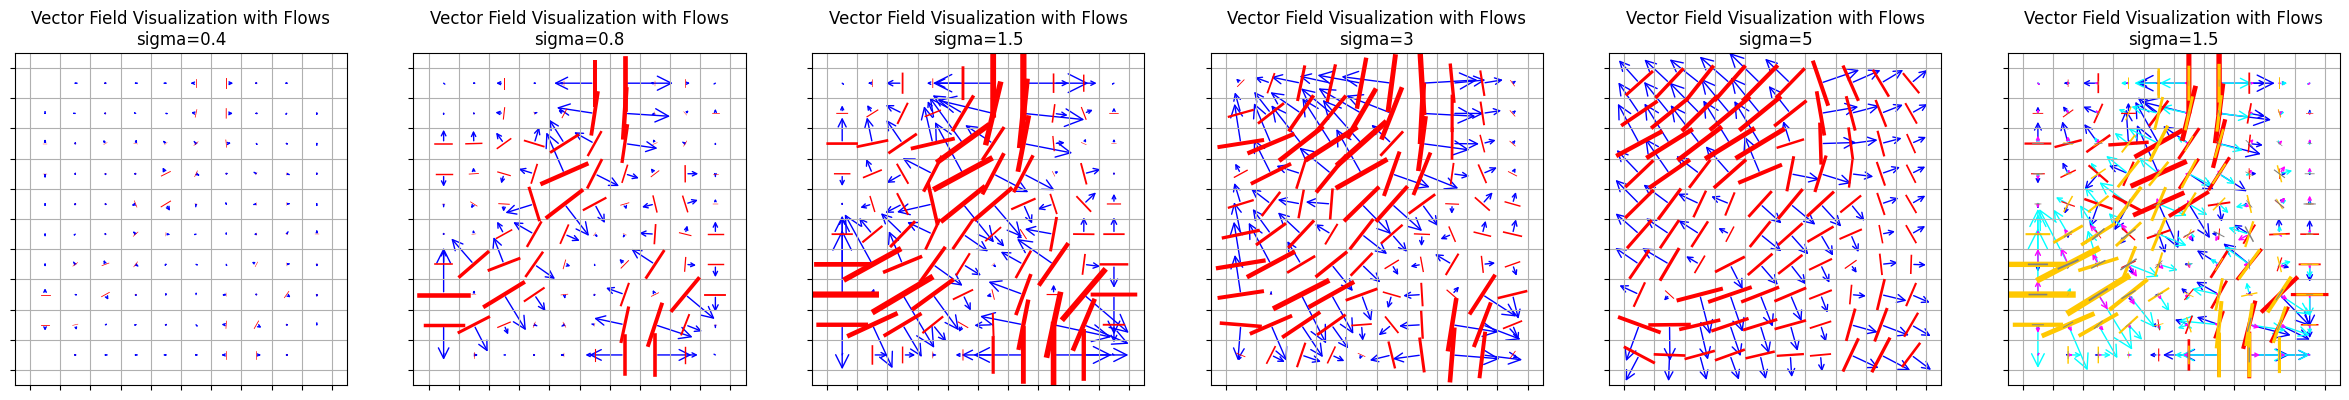

In [17]:
visualize_vector_field(n_rows10, n_columns10, res_weights_clusters10, idataClusters['vec_dim'], [
	Config([[0,1,2]], 0.4, True, True, 1), 
	Config([[0,1,2]], 0.8, True, True, 1), 
	Config([[0,1,2]], 1.5, True, True, 1), 
	Config([[0,1,2]], 3, True, True, 1), 
	Config([[0,1,2]], 5, True, True, 1), 
	Config([[0],[1],[2]], 1.5, True, True, 1)])

#### with 100x60

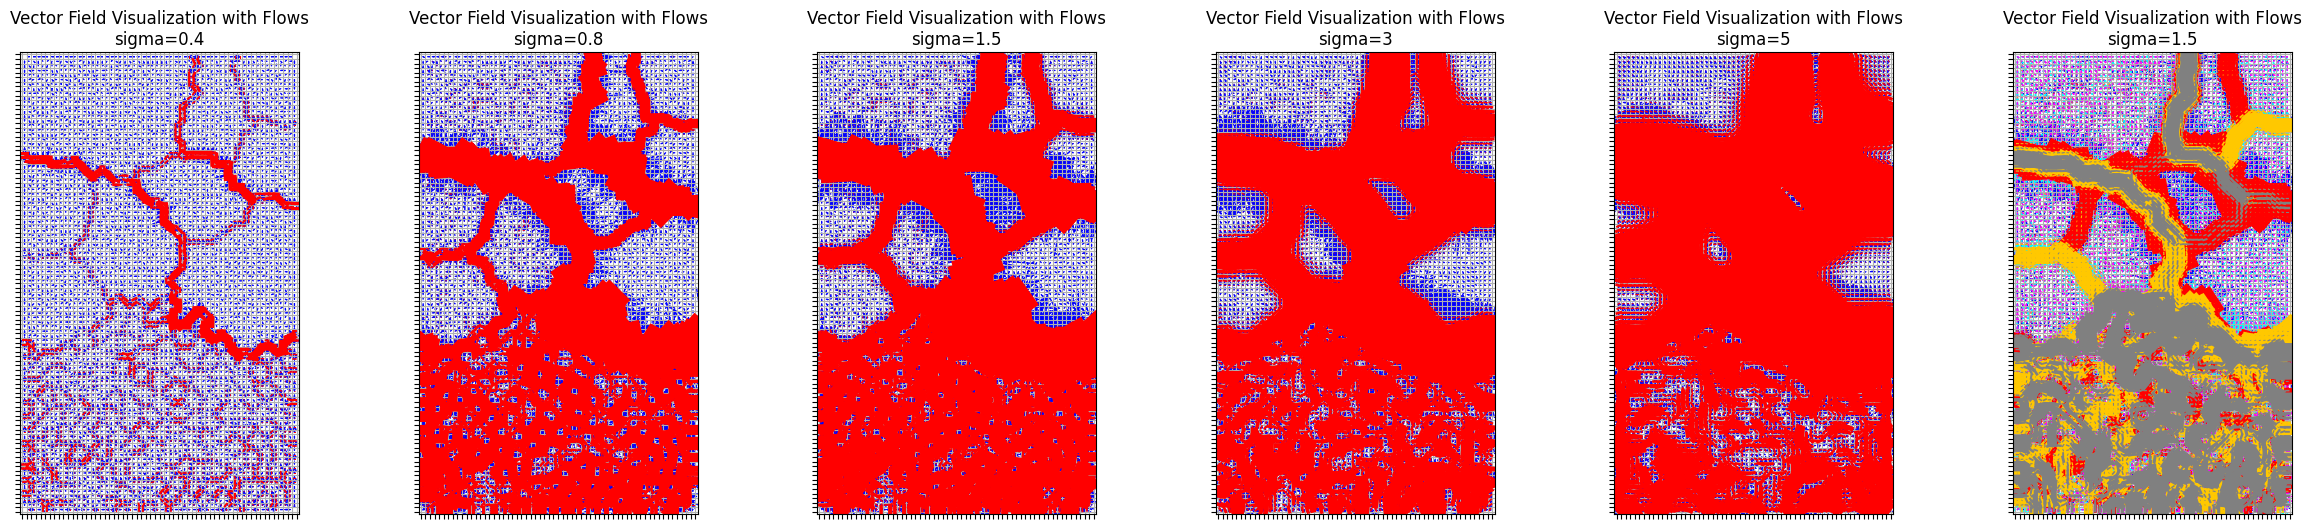

In [20]:
visualize_vector_field(n_rows100, n_columns100, res_weights_clusters100, idataClusters['vec_dim'], [
	Config([[0,1,2]], 0.4, True, True, 5), 
	Config([[0,1,2]], 0.8, True, True, 5), 
	Config([[0,1,2]], 1.5, True, True, 5), 
	Config([[0,1,2]], 3, True, True, 5), 
	Config([[0,1,2]], 5, True, True, 5), 
	Config([[0],[1],[2]], 1.5, True, True, 5)])

## Comparison with the Java Toolbox

### Our visualization

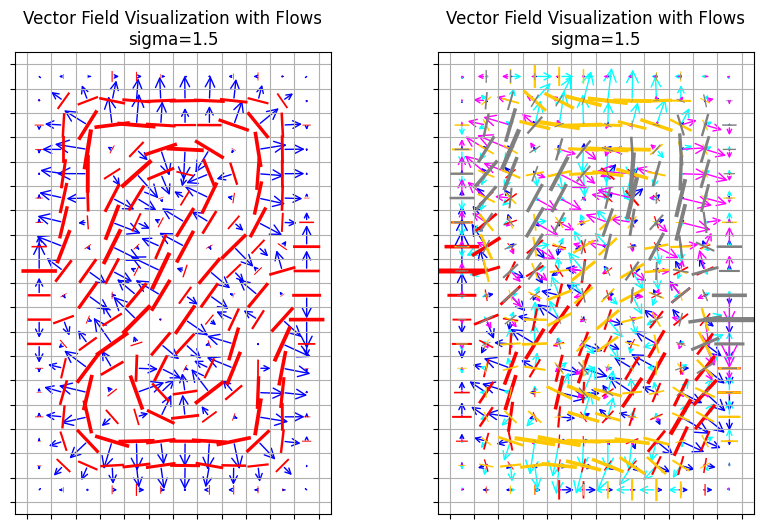

In [8]:
chainWeights  = SOMToolBox_Parse("chainlink_from_java.wgt").read_weight_file()
n_rows = chainWeights['ydim']
n_columns = chainWeights['xdim']

visualize_vector_field(n_rows,n_columns, chainWeights['arr'], chainWeights['vec_dim'], [
	Config([[0,1,2]], 1.5, True, True, 10), 
	Config([[0],[1],[2]], 1.5, True, True, 10)])

### Java Toolbox visualization

<img src="img/sig1.5.PNG" alt="Toolbox result for sigma=1.5, 1 group" width="350"/>
<img src="img/sig1.5_each_dim_a_group.PNG" alt="Toolbox result for sigma=1.5, 3 groups" width="350"/>